In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import random
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 160
EPOCHS = 21
BATCH_SIZE = 64
LEARNING_RATE = 0.001

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
device = torch.device(device)

train_type_dir = '../data/train/type'
train_nrj_dir = '../data/train/nrj'
test_dir = '../data/test/'

cuda


In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE), 
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])
                                       ])

testval_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                                       ])

In [4]:
def load_split_train_valid(datadir, batch_size, train_transforms, valid_transforms, valid_size):

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir, transform=testval_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)   

    return trainloader, valloader

In [5]:
train_type_loader, val_type_loader = load_split_train_valid(datadir=train_type_dir,
                           batch_size=BATCH_SIZE,
                           train_transforms=train_transforms,
                           valid_transforms=testval_transforms,
                           valid_size = .2)

print(train_type_loader.dataset.classes)
print(val_type_loader.dataset.classes)
print(len(train_type_loader))
print(len(val_type_loader))
train_type_loader.dataset.class_to_idx

['ER', 'NR']
['ER', 'NR']
166
42


{'ER': 0, 'NR': 1}

In [6]:
train_nrj_loader, val_nrj_loader = load_split_train_valid(datadir=train_nrj_dir,
                           batch_size=BATCH_SIZE,
                           train_transforms=train_transforms,
                           valid_transforms=testval_transforms,
                           valid_size = .2)

print(train_nrj_loader.dataset.classes)
print(val_nrj_loader.dataset.classes)
print(len(train_nrj_loader))
print(len(val_nrj_loader))
train_nrj_loader.dataset.class_to_idx

['1', '10', '20', '3', '30', '6']
['1', '10', '20', '3', '30', '6']
166
42


{'1': 0, '10': 1, '20': 2, '3': 3, '30': 4, '6': 5}

In [7]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, testval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
len(test_loader), len(test_dataset)

(259, 16560)

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                hystory_loss_train.append(epoch_loss)
                hystory_acc_train.append(epoch_acc)
                scheduler.step()
            else:
                hystory_loss_val.append(epoch_loss)
                hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

In [10]:
class SCNc2(nn.Module):
    def __init__(self):
        super(SCNc2, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(3),
            nn.ReLU(), 
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(3),
            nn.ReLU(),  
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
           
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=8192, out_features=1024),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=32),
            nn.ReLU()
        )

        self.fc3 = nn.Linear(in_features=32, out_features=2)
      
    def forward(self, x):
        # First block
        residual_1 = x
        out = self.c1(x)
        out += residual_1
        #print(out.shape)
  
        # Second block
        residual_2 = out
        out = self.c2(x)
        out += residual_2
        
        out = self.c3(out)
        out = self.c4(out)
  
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

Epoch 0/20:



train Loss: 0.5883 Acc: 0.6542



val Loss: 0.4478 Acc: 0.8445
Epoch 1/20:



train Loss: 0.3388 Acc: 0.8798



val Loss: 0.2101 Acc: 0.9706
Epoch 2/20:



train Loss: 0.1453 Acc: 0.9696



val Loss: 0.1180 Acc: 0.9732
Epoch 3/20:



train Loss: 0.0782 Acc: 0.9838



val Loss: 0.0704 Acc: 0.9866
Epoch 4/20:



train Loss: 0.0523 Acc: 0.9892



val Loss: 0.0508 Acc: 0.9900
Epoch 5/20:



train Loss: 0.0396 Acc: 0.9936



val Loss: 0.0448 Acc: 0.9922
Epoch 6/20:



train Loss: 0.0378 Acc: 0.9940



val Loss: 0.0436 Acc: 0.9929
Epoch 7/20:



train Loss: 0.0380 Acc: 0.9935



val Loss: 0.0435 Acc: 0.9929
Epoch 8/20:



train Loss: 0.0365 Acc: 0.9935



val Loss: 0.0414 Acc: 0.9933
Epoch 9/20:



train Loss: 0.0360 Acc: 0.9943



val Loss: 0.0396 Acc: 0.9929
Epoch 10/20:



train Loss: 0.0350 Acc: 0.9953



val Loss: 0.0399 Acc: 0.9933
Epoch 11/20:



train Loss: 0.0348 Acc: 0.9952



val Loss: 0.0409 Acc: 0.9929
Epoch 12/20:



train Loss: 0.0353 Acc: 0.9942



val Loss: 0.0407 Acc: 0.9922
Epoch 13/20:



train Loss: 0.0347 Acc: 0.9938



val Loss: 0.0409 Acc: 0.9922
Epoch 14/20:



train Loss: 0.0344 Acc: 0.9946



val Loss: 0.0410 Acc: 0.9929
Epoch 15/20:



train Loss: 0.0349 Acc: 0.9937



val Loss: 0.0414 Acc: 0.9933
Epoch 16/20:



train Loss: 0.0348 Acc: 0.9949



val Loss: 0.0399 Acc: 0.9922
Epoch 17/20:



train Loss: 0.0347 Acc: 0.9947



val Loss: 0.0408 Acc: 0.9929
Epoch 18/20:



train Loss: 0.0348 Acc: 0.9953



val Loss: 0.0408 Acc: 0.9933
Epoch 19/20:



train Loss: 0.0370 Acc: 0.9939



val Loss: 0.0409 Acc: 0.9937
Epoch 20/20:



train Loss: 0.0351 Acc: 0.9944



val Loss: 0.0399 Acc: 0.9926



Epoch 0/20:



train Loss: 0.5680 Acc: 0.7072



val Loss: 0.3984 Acc: 0.9788
Epoch 1/20:



train Loss: 0.2572 Acc: 0.9318



val Loss: 0.1629 Acc: 0.9888
Epoch 2/20:



train Loss: 0.1158 Acc: 0.9819



val Loss: 0.0999 Acc: 0.9888
Epoch 3/20:



train Loss: 0.0726 Acc: 0.9882



val Loss: 0.0666 Acc: 0.9918
Epoch 4/20:



train Loss: 0.0534 Acc: 0.9914



val Loss: 0.0496 Acc: 0.9903
Epoch 5/20:



train Loss: 0.0420 Acc: 0.9942



val Loss: 0.0478 Acc: 0.9922
Epoch 6/20:



train Loss: 0.0418 Acc: 0.9942



val Loss: 0.0467 Acc: 0.9929
Epoch 7/20:



train Loss: 0.0419 Acc: 0.9932



val Loss: 0.0450 Acc: 0.9922
Epoch 8/20:



train Loss: 0.0407 Acc: 0.9937



val Loss: 0.0446 Acc: 0.9926
Epoch 9/20:



train Loss: 0.0388 Acc: 0.9938



val Loss: 0.0445 Acc: 0.9922
Epoch 10/20:



train Loss: 0.0381 Acc: 0.9950



val Loss: 0.0441 Acc: 0.9922
Epoch 11/20:



train Loss: 0.0379 Acc: 0.9951



val Loss: 0.0441 Acc: 0.9926
Epoch 12/20:



train Loss: 0.0379 Acc: 0.9949



val Loss: 0.0435 Acc: 0.9926
Epoch 13/20:



train Loss: 0.0384 Acc: 0.9953



val Loss: 0.0431 Acc: 0.9926
Epoch 14/20:



train Loss: 0.0388 Acc: 0.9937



val Loss: 0.0423 Acc: 0.9922
Epoch 15/20:



train Loss: 0.0392 Acc: 0.9934



val Loss: 0.0427 Acc: 0.9929
Epoch 16/20:



train Loss: 0.0398 Acc: 0.9928



val Loss: 0.0459 Acc: 0.9922
Epoch 17/20:



train Loss: 0.0386 Acc: 0.9940



val Loss: 0.0433 Acc: 0.9922
Epoch 18/20:



train Loss: 0.0385 Acc: 0.9942



val Loss: 0.0430 Acc: 0.9926
Epoch 19/20:



train Loss: 0.0377 Acc: 0.9949



val Loss: 0.0438 Acc: 0.9926
Epoch 20/20:



train Loss: 0.0373 Acc: 0.9945



val Loss: 0.0427 Acc: 0.9926



Epoch 0/20:



train Loss: 0.5712 Acc: 0.7027



val Loss: 0.3950 Acc: 0.7738
Epoch 1/20:



train Loss: 0.2803 Acc: 0.9052



val Loss: 0.1903 Acc: 0.9650
Epoch 2/20:



train Loss: 0.1285 Acc: 0.9762



val Loss: 0.1023 Acc: 0.9888
Epoch 3/20:



train Loss: 0.0828 Acc: 0.9841



val Loss: 0.0954 Acc: 0.9754
Epoch 4/20:



train Loss: 0.0606 Acc: 0.9879



val Loss: 0.0578 Acc: 0.9903
Epoch 5/20:



train Loss: 0.0497 Acc: 0.9917



val Loss: 0.0548 Acc: 0.9914
Epoch 6/20:



train Loss: 0.0471 Acc: 0.9935



val Loss: 0.0557 Acc: 0.9907
Epoch 7/20:



train Loss: 0.0473 Acc: 0.9922



val Loss: 0.0517 Acc: 0.9922
Epoch 8/20:



train Loss: 0.0464 Acc: 0.9917



val Loss: 0.0521 Acc: 0.9914
Epoch 9/20:



train Loss: 0.0446 Acc: 0.9921



val Loss: 0.0492 Acc: 0.9926
Epoch 10/20:



train Loss: 0.0444 Acc: 0.9923



val Loss: 0.0517 Acc: 0.9914
Epoch 11/20:



train Loss: 0.0437 Acc: 0.9931



val Loss: 0.0511 Acc: 0.9918
Epoch 12/20:



train Loss: 0.0445 Acc: 0.9926



val Loss: 0.0509 Acc: 0.9922
Epoch 13/20:



train Loss: 0.0437 Acc: 0.9944



val Loss: 0.0511 Acc: 0.9922
Epoch 14/20:



train Loss: 0.0443 Acc: 0.9925



val Loss: 0.0506 Acc: 0.9922
Epoch 15/20:



train Loss: 0.0446 Acc: 0.9937



val Loss: 0.0505 Acc: 0.9926
Epoch 16/20:



train Loss: 0.0433 Acc: 0.9936



val Loss: 0.0499 Acc: 0.9922
Epoch 17/20:



train Loss: 0.0440 Acc: 0.9932



val Loss: 0.0500 Acc: 0.9926
Epoch 18/20:



train Loss: 0.0429 Acc: 0.9935



val Loss: 0.0509 Acc: 0.9918
Epoch 19/20:



train Loss: 0.0428 Acc: 0.9939



val Loss: 0.0498 Acc: 0.9922
Epoch 20/20:



train Loss: 0.0445 Acc: 0.9924



val Loss: 0.0494 Acc: 0.9926



Epoch 0/20:



train Loss: 0.6353 Acc: 0.6313



val Loss: 0.5392 Acc: 0.7612
Epoch 1/20:



train Loss: 0.4534 Acc: 0.8085



val Loss: 0.3489 Acc: 0.9334
Epoch 2/20:



train Loss: 0.2512 Acc: 0.9478



val Loss: 0.1606 Acc: 0.9866
Epoch 3/20:



train Loss: 0.1153 Acc: 0.9880



val Loss: 0.0920 Acc: 0.9922
Epoch 4/20:



train Loss: 0.0711 Acc: 0.9914



val Loss: 0.0638 Acc: 0.9944
Epoch 5/20:



train Loss: 0.0551 Acc: 0.9944



val Loss: 0.0595 Acc: 0.9955
Epoch 6/20:



train Loss: 0.0531 Acc: 0.9951



val Loss: 0.0583 Acc: 0.9955
Epoch 7/20:



train Loss: 0.0509 Acc: 0.9954



val Loss: 0.0582 Acc: 0.9952
Epoch 8/20:



train Loss: 0.0492 Acc: 0.9950



val Loss: 0.0551 Acc: 0.9955
Epoch 9/20:



train Loss: 0.0484 Acc: 0.9957



val Loss: 0.0532 Acc: 0.9948
Epoch 10/20:



train Loss: 0.0483 Acc: 0.9945



val Loss: 0.0532 Acc: 0.9955
Epoch 11/20:



train Loss: 0.0488 Acc: 0.9947



val Loss: 0.0535 Acc: 0.9955
Epoch 12/20:



train Loss: 0.0479 Acc: 0.9960



val Loss: 0.0540 Acc: 0.9952
Epoch 13/20:



train Loss: 0.0474 Acc: 0.9948



val Loss: 0.0519 Acc: 0.9955
Epoch 14/20:



train Loss: 0.0473 Acc: 0.9944



val Loss: 0.0534 Acc: 0.9955
Epoch 15/20:



train Loss: 0.0472 Acc: 0.9949



val Loss: 0.0526 Acc: 0.9955
Epoch 16/20:



train Loss: 0.0474 Acc: 0.9948



val Loss: 0.0530 Acc: 0.9955
Epoch 17/20:



train Loss: 0.0472 Acc: 0.9952



val Loss: 0.0536 Acc: 0.9952
Epoch 18/20:



train Loss: 0.0468 Acc: 0.9949



val Loss: 0.0520 Acc: 0.9955
Epoch 19/20:



train Loss: 0.0474 Acc: 0.9948



val Loss: 0.0529 Acc: 0.9955
Epoch 20/20:



train Loss: 0.0468 Acc: 0.9946



val Loss: 0.0528 Acc: 0.9955



Epoch 0/20:



train Loss: 0.6126 Acc: 0.6460



val Loss: 0.5199 Acc: 0.7548
Epoch 1/20:



train Loss: 0.4715 Acc: 0.7716



val Loss: 0.3929 Acc: 0.9542
Epoch 2/20:



train Loss: 0.2999 Acc: 0.9006



val Loss: 0.2138 Acc: 0.9781
Epoch 3/20:



train Loss: 0.1571 Acc: 0.9654



val Loss: 0.1309 Acc: 0.9702
Epoch 4/20:



train Loss: 0.0924 Acc: 0.9861



val Loss: 0.0840 Acc: 0.9866
Epoch 5/20:



train Loss: 0.0700 Acc: 0.9915



val Loss: 0.0767 Acc: 0.9903
Epoch 6/20:



train Loss: 0.0661 Acc: 0.9917



val Loss: 0.0770 Acc: 0.9918
Epoch 7/20:



train Loss: 0.0649 Acc: 0.9920



val Loss: 0.0718 Acc: 0.9914
Epoch 8/20:



train Loss: 0.0628 Acc: 0.9915



val Loss: 0.0686 Acc: 0.9907
Epoch 9/20:



train Loss: 0.0609 Acc: 0.9928



val Loss: 0.0699 Acc: 0.9926
Epoch 10/20:



train Loss: 0.0601 Acc: 0.9919



val Loss: 0.0680 Acc: 0.9926
Epoch 11/20:



train Loss: 0.0598 Acc: 0.9935



val Loss: 0.0676 Acc: 0.9922
Epoch 12/20:



train Loss: 0.0602 Acc: 0.9928



val Loss: 0.0681 Acc: 0.9922
Epoch 13/20:



train Loss: 0.0591 Acc: 0.9923



val Loss: 0.0670 Acc: 0.9926
Epoch 14/20:



train Loss: 0.0596 Acc: 0.9924



val Loss: 0.0677 Acc: 0.9922
Epoch 15/20:



train Loss: 0.0598 Acc: 0.9928



val Loss: 0.0665 Acc: 0.9922
Epoch 16/20:



train Loss: 0.0591 Acc: 0.9927



val Loss: 0.0660 Acc: 0.9922
Epoch 17/20:



train Loss: 0.0589 Acc: 0.9925



val Loss: 0.0671 Acc: 0.9926
Epoch 18/20:



train Loss: 0.0585 Acc: 0.9923



val Loss: 0.0678 Acc: 0.9922
Epoch 19/20:



train Loss: 0.0583 Acc: 0.9929



val Loss: 0.0670 Acc: 0.9922
Epoch 20/20:



train Loss: 0.0600 Acc: 0.9921



val Loss: 0.0684 Acc: 0.9922



Epoch 0/20:



train Loss: 0.5858 Acc: 0.6603



val Loss: 0.4843 Acc: 0.7809
Epoch 1/20:



train Loss: 0.3705 Acc: 0.8663



val Loss: 0.2395 Acc: 0.9900
Epoch 2/20:



train Loss: 0.1726 Acc: 0.9745



val Loss: 0.1349 Acc: 0.9803
Epoch 3/20:



train Loss: 0.0981 Acc: 0.9860



val Loss: 0.0822 Acc: 0.9944
Epoch 4/20:



train Loss: 0.0640 Acc: 0.9913



val Loss: 0.0561 Acc: 0.9933
Epoch 5/20:



train Loss: 0.0519 Acc: 0.9915



val Loss: 0.0586 Acc: 0.9955
Epoch 6/20:



train Loss: 0.0498 Acc: 0.9935



val Loss: 0.0531 Acc: 0.9952
Epoch 7/20:



train Loss: 0.0476 Acc: 0.9933



val Loss: 0.0526 Acc: 0.9944
Epoch 8/20:



train Loss: 0.0469 Acc: 0.9942



val Loss: 0.0507 Acc: 0.9948
Epoch 9/20:



train Loss: 0.0452 Acc: 0.9945



val Loss: 0.0498 Acc: 0.9952
Epoch 10/20:



train Loss: 0.0460 Acc: 0.9925



val Loss: 0.0516 Acc: 0.9952
Epoch 11/20:



train Loss: 0.0454 Acc: 0.9939



val Loss: 0.0517 Acc: 0.9952
Epoch 12/20:



train Loss: 0.0456 Acc: 0.9936



val Loss: 0.0523 Acc: 0.9955
Epoch 13/20:



train Loss: 0.0453 Acc: 0.9940



val Loss: 0.0505 Acc: 0.9955
Epoch 14/20:



train Loss: 0.0437 Acc: 0.9949



val Loss: 0.0519 Acc: 0.9948
Epoch 15/20:



train Loss: 0.0461 Acc: 0.9937



val Loss: 0.0507 Acc: 0.9955
Epoch 16/20:



train Loss: 0.0447 Acc: 0.9944



val Loss: 0.0506 Acc: 0.9952
Epoch 17/20:



train Loss: 0.0445 Acc: 0.9938



val Loss: 0.0517 Acc: 0.9955
Epoch 18/20:



train Loss: 0.0439 Acc: 0.9947



val Loss: 0.0499 Acc: 0.9955
Epoch 19/20:



train Loss: 0.0442 Acc: 0.9949



val Loss: 0.0506 Acc: 0.9955
Epoch 20/20:



train Loss: 0.0446 Acc: 0.9940



val Loss: 0.0511 Acc: 0.9952



Epoch 0/20:



train Loss: 0.5971 Acc: 0.6611



val Loss: 0.5141 Acc: 0.7184
Epoch 1/20:



train Loss: 0.4190 Acc: 0.8285



val Loss: 0.3073 Acc: 0.9714
Epoch 2/20:



train Loss: 0.2239 Acc: 0.9408



val Loss: 0.1524 Acc: 0.9866
Epoch 3/20:



train Loss: 0.1205 Acc: 0.9778



val Loss: 0.0935 Acc: 0.9900
Epoch 4/20:



train Loss: 0.0761 Acc: 0.9882



val Loss: 0.0682 Acc: 0.9900
Epoch 5/20:



train Loss: 0.0596 Acc: 0.9915



val Loss: 0.0619 Acc: 0.9933
Epoch 6/20:



train Loss: 0.0579 Acc: 0.9923



val Loss: 0.0613 Acc: 0.9922
Epoch 7/20:



train Loss: 0.0564 Acc: 0.9931



val Loss: 0.0578 Acc: 0.9940
Epoch 8/20:



train Loss: 0.0542 Acc: 0.9928



val Loss: 0.0573 Acc: 0.9937
Epoch 9/20:



train Loss: 0.0547 Acc: 0.9922



val Loss: 0.0559 Acc: 0.9929
Epoch 10/20:



train Loss: 0.0519 Acc: 0.9928



val Loss: 0.0566 Acc: 0.9933
Epoch 11/20:



train Loss: 0.0526 Acc: 0.9934



val Loss: 0.0571 Acc: 0.9933
Epoch 12/20:



train Loss: 0.0535 Acc: 0.9930



val Loss: 0.0559 Acc: 0.9944
Epoch 13/20:



train Loss: 0.0527 Acc: 0.9929



val Loss: 0.0550 Acc: 0.9944
Epoch 14/20:



train Loss: 0.0520 Acc: 0.9934



val Loss: 0.0558 Acc: 0.9933
Epoch 15/20:



train Loss: 0.0526 Acc: 0.9920



val Loss: 0.0558 Acc: 0.9940
Epoch 16/20:



train Loss: 0.0518 Acc: 0.9935



val Loss: 0.0568 Acc: 0.9940
Epoch 17/20:



train Loss: 0.0521 Acc: 0.9927



val Loss: 0.0548 Acc: 0.9933
Epoch 18/20:



train Loss: 0.0536 Acc: 0.9926



val Loss: 0.0555 Acc: 0.9937
Epoch 19/20:



train Loss: 0.0523 Acc: 0.9926



val Loss: 0.0552 Acc: 0.9937
Epoch 20/20:



train Loss: 0.0509 Acc: 0.9942



val Loss: 0.0575 Acc: 0.9929



Epoch 0/20:



train Loss: 0.6912 Acc: 0.6097



val Loss: 0.5582 Acc: 0.7251
Epoch 1/20:



train Loss: 0.5138 Acc: 0.7454



val Loss: 0.4461 Acc: 0.8538
Epoch 2/20:



train Loss: 0.3733 Acc: 0.8721



val Loss: 0.2744 Acc: 0.9208
Epoch 3/20:



train Loss: 0.2213 Acc: 0.9412



val Loss: 0.1533 Acc: 0.9881
Epoch 4/20:



train Loss: 0.1273 Acc: 0.9749



val Loss: 0.0917 Acc: 0.9881
Epoch 5/20:



train Loss: 0.0918 Acc: 0.9862



val Loss: 0.0920 Acc: 0.9907
Epoch 6/20:



train Loss: 0.0879 Acc: 0.9875



val Loss: 0.0860 Acc: 0.9914
Epoch 7/20:



train Loss: 0.0852 Acc: 0.9891



val Loss: 0.0856 Acc: 0.9911
Epoch 8/20:



train Loss: 0.0819 Acc: 0.9891



val Loss: 0.0807 Acc: 0.9918
Epoch 9/20:



train Loss: 0.0789 Acc: 0.9889



val Loss: 0.0800 Acc: 0.9918
Epoch 10/20:



train Loss: 0.0787 Acc: 0.9898



val Loss: 0.0781 Acc: 0.9918
Epoch 11/20:



train Loss: 0.0772 Acc: 0.9891



val Loss: 0.0784 Acc: 0.9914
Epoch 12/20:



train Loss: 0.0776 Acc: 0.9893



val Loss: 0.0775 Acc: 0.9918
Epoch 13/20:



train Loss: 0.0770 Acc: 0.9890



val Loss: 0.0786 Acc: 0.9914
Epoch 14/20:



train Loss: 0.0778 Acc: 0.9891



val Loss: 0.0775 Acc: 0.9918
Epoch 15/20:



train Loss: 0.0762 Acc: 0.9895



val Loss: 0.0769 Acc: 0.9918
Epoch 16/20:



train Loss: 0.0764 Acc: 0.9900



val Loss: 0.0769 Acc: 0.9918
Epoch 17/20:



train Loss: 0.0763 Acc: 0.9901



val Loss: 0.0769 Acc: 0.9918
Epoch 18/20:



train Loss: 0.0768 Acc: 0.9899



val Loss: 0.0769 Acc: 0.9922
Epoch 19/20:



train Loss: 0.0769 Acc: 0.9898



val Loss: 0.0778 Acc: 0.9918
Epoch 20/20:



train Loss: 0.0777 Acc: 0.9884



val Loss: 0.0778 Acc: 0.9918




Wall time: 2h 49min 47s


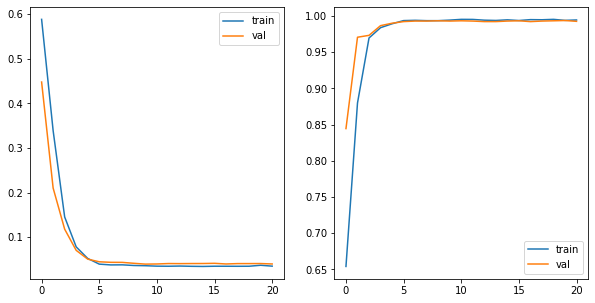

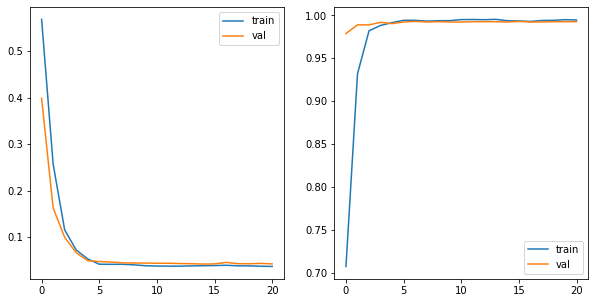

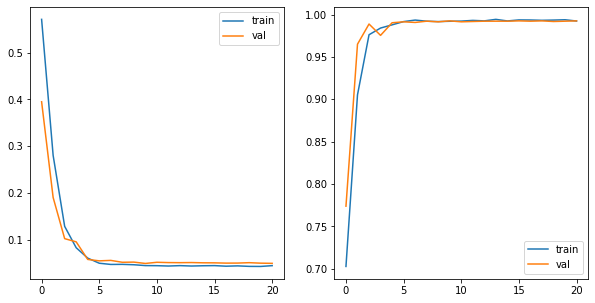

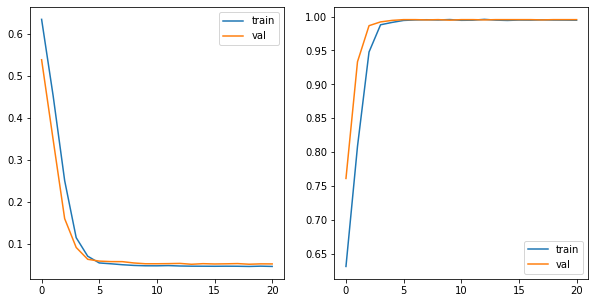

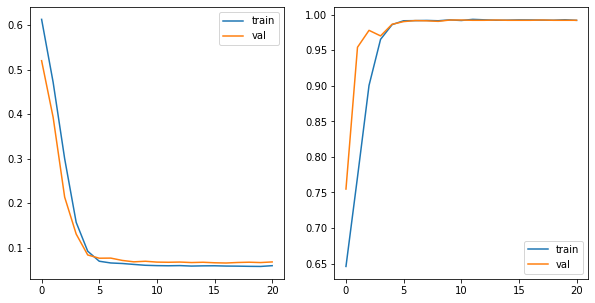

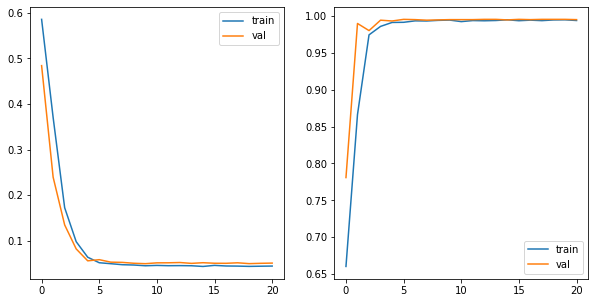

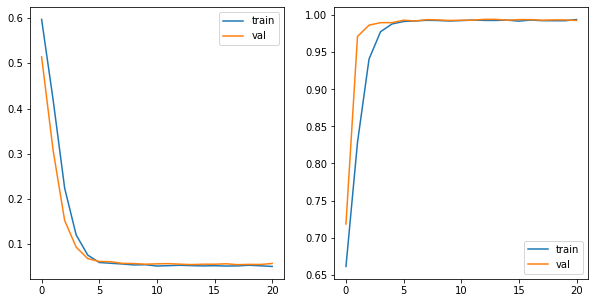

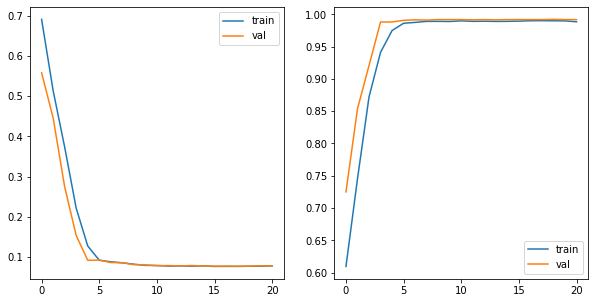

In [11]:
%%time
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
    file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred['id'] = file_names

for i in trange(8):
    set_seed(SEED+i)
    
    net = SCNc2()
    net = net.to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adagrad(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
    train_model(net, loss, optimizer, scheduler, EPOCHS, train_type_loader, val_type_loader);
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(hystory_loss_train, label='train')
    ax1.plot(hystory_loss_val, label='val')
    ax1.legend()

    ax2.plot(hystory_acc_train, label='train')
    ax2.plot(hystory_acc_val, label='val')
    ax2.legend()
    
    net.eval()
    dict_pred[f'SCNc2-{i}'] = []
    with torch.no_grad():
        for _, (img, name) in enumerate(tqdm(test_loader)):
            img = img.to(device)
            outputs = net(img)
            _, predicted = torch.max(outputs.data, dim=1)
            predicted = list(map(int, predicted.cpu()))
            dict_pred[f'SCNc2-{i}'].extend(predicted)

    del net
    torch.cuda.empty_cache()

In [39]:
data_frame = pd.DataFrame.from_dict(dict_pred)
data_frame.head()

,id,SCNc2-0,SCNc2-1,SCNc2-2,SCNc2-3,SCNc2-4,SCNc2-5,SCNc2-6,SCNc2-7
0,private_test\\00013a94f1fae3e5a33f8b44c2842c85...,0,0,0,0,0,0,0,0
1,private_test\\0005564c011259402dcb6e3beb6e64d2...,0,0,0,0,0,0,0,0
2,private_test\\0007520c8d8efade8feaafbf74fc7d20...,1,1,1,1,1,1,1,1
3,private_test\\000804a189f630cd980ff1543c0ef99d...,1,1,1,1,1,1,1,1
4,private_test\\000eb12def5371089743dcfe401a8e39...,1,1,1,1,1,1,1,1


In [40]:
data_frame['SCNc2-0'] = data_frame['SCNc2-0'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-1'] = data_frame['SCNc2-1'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-2'] = data_frame['SCNc2-2'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-3'] = data_frame['SCNc2-3'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-4'] = data_frame['SCNc2-4'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-5'] = data_frame['SCNc2-5'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-6'] = data_frame['SCNc2-6'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['SCNc2-7'] = data_frame['SCNc2-7'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame.head()

,id,SCNc2-0,SCNc2-1,SCNc2-2,SCNc2-3,SCNc2-4,SCNc2-5,SCNc2-6,SCNc2-7
0,private_test\\00013a94f1fae3e5a33f8b44c2842c85...,1,1,1,1,1,1,1,1
1,private_test\\0005564c011259402dcb6e3beb6e64d2...,1,1,1,1,1,1,1,1
2,private_test\\0007520c8d8efade8feaafbf74fc7d20...,0,0,0,0,0,0,0,0
3,private_test\\000804a189f630cd980ff1543c0ef99d...,0,0,0,0,0,0,0,0
4,private_test\\000eb12def5371089743dcfe401a8e39...,0,0,0,0,0,0,0,0


In [41]:
data_frame['id'] = data_frame['id'].apply(lambda x: x.split('\\\\')[1])
data_frame.head()

,id,SCNc2-0,SCNc2-1,SCNc2-2,SCNc2-3,SCNc2-4,SCNc2-5,SCNc2-6,SCNc2-7
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1,1,1,1,1,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,1,1,1,1,1,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0,0,0,0,0,0,0,0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0,0,0,0,0,0,0,0
4,000eb12def5371089743dcfe401a8e399f5883fc,0,0,0,0,0,0,0,0


In [43]:
data_frame.to_csv('SCNc2.csv', index=False, header=True)